# Libraries Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from PIL import ImageFont

import joblib
from geexhp import datasetup as dset

from tensorflow.keras.utils import plot_model # type: ignore
import visualkeras
from geexhp import datavis
datavis.configure_matplotlib()

from geexhp import cnn

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Data Setup

In [2]:
#folder = "../parallel/data/"
#df = dset.combine_parquet(folder=folder, keyword="_", output_file=True)

In [3]:
df = pd.read_parquet("../data/__data.parquet")

In [4]:
dfabun = dset.extract_abundances(df)
dfabun.dropna(inplace=True)

# Preprocessing data and creating the training and testing datasets

In [5]:
abundance_features = ["C2H6","CH4","CO","CO2","H2","H2O","HCN","N2","N2O","NH3","O2","O3","PH3"]
planetary_features = ["ATMOSPHERE-PRESSURE","ATMOSPHERE-TEMPERATURE", "OBJECT-DIAMETER", "OBJECT-GRAVITY"]

abundance_units = len(abundance_features)
planetary_units = len(planetary_features)

y_abundance = dfabun[abundance_features].values
y_planetary = dfabun[planetary_features].values

albedo = np.array([np.array(d) for d in dfabun['ALBEDO'].to_numpy()])

In [6]:
X_train, X_test, y_abundance_train, y_abundance_test, y_planetary_train, y_planetary_test = train_test_split(
    albedo, y_abundance, y_planetary, test_size=0.2, random_state=42, stratify=dfabun["Earth_type"])

In [7]:
(X_train_scaled, X_test_scaled,
 y_abundance_train_scaled, y_abundance_test_scaled,
 y_planetary_train_scaled, y_planetary_test_scaled,
 x_scaler, y_scalers_abundance, y_scalers_planetary) = dset.normalize_data(
    X_train, X_test,
    y_abundance_train, y_abundance_test,
    y_planetary_train, y_planetary_test
)

Train input shape: (31800, 2304, 1)
Test input shape: (7951, 2304, 1)
Train abundance labels shape: (31800, 13)
Test abundance labels shape: (7951, 13)
Train planetary labels shape: (31800, 4)
Test planetary labels shape: (7951, 4)


In [8]:
joblib.dump(x_scaler, '../models/x_scaler.joblib')
joblib.dump(y_scalers_abundance, '../models/y_scalers_abundance.joblib')
joblib.dump(y_scalers_planetary, '../models/y_scalers_planetary.joblib')

['../models/y_scalers_planetary.joblib']

In [9]:
# Write the training data to TFRecords
dset.write_tfrecords('../data/train.tfrecords', X_train_scaled, y_abundance_train_scaled, y_planetary_train_scaled)

# Write the testing data to TFRecords
dset.write_tfrecords('../data/test.tfrecords', X_test_scaled, y_abundance_test_scaled, y_planetary_test_scaled)

Data successfully written to ../data/train.tfrecords
Data successfully written to ../data/test.tfrecords


In [10]:
feature_description = {
    'input_albedo': tf.io.FixedLenFeature([X_train_scaled.shape[1]], tf.float32),
    'abundance_labels': tf.io.FixedLenFeature([y_abundance_train_scaled.shape[1]], tf.float32),
    'planetary_labels': tf.io.FixedLenFeature([y_planetary_train_scaled.shape[1]], tf.float32),
}

In [11]:
def _parse_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    input_albedo = parsed_example['input_albedo']
    abundance_labels = parsed_example['abundance_labels']
    planetary_labels = parsed_example['planetary_labels']

    # Reshape input_albedo to match the expected input shape for Conv1D layers
    input_albedo = tf.reshape(input_albedo, [X_train_scaled.shape[1], 1])

    return input_albedo, {'abundance_output': abundance_labels, 'planetary_output': planetary_labels}

In [12]:
batch_size = 16

# Training dataset
train_dataset = tf.data.TFRecordDataset('../data/train.tfrecords')
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(buffer_size=1000)
#train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Testing dataset
test_dataset = tf.data.TFRecordDataset('../data/test.tfrecords')
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
subset_size = 2000
X_tune = X_train_scaled[:subset_size].reshape(subset_size, -1)
y_abundance_tune = y_abundance_train_scaled[:subset_size]
y_planetary_tune = y_planetary_train_scaled[:subset_size]

In [14]:
abundance_features = ["C2H6","CH4","CO","CO2","H2","H2O","HCN","N2","N2O","NH3","O2","O3","PH3"]
planetary_features = ["PRESSURE","TEMPERATURE", "DIAMETER", "GRAVITY"]

# Convolutional Neural Network 1D (CNN) with tuning hyperparameters

In [15]:
hypertuner = cnn.HyperTuningBayCNN(
    input_shape=(X_train_scaled.shape[1], 1),
    abundance_units=len(abundance_features),
    planetary_units=len(planetary_features)
)

search = hypertuner.search(X_tune, y_abundance_tune, y_planetary_tune, max_trials=30, search_epochs=3)

Trial 30 Complete [00h 02m 11s]
val_loss: 0.24183402955532074

Best val_loss So Far: 0.20125116407871246
Total elapsed time: 00h 36m 05s


In [16]:
train_dataset_size = sum(1 for _ in train_dataset)
validation_size = int(0.2 * train_dataset_size)
train_size = train_dataset_size - validation_size

validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

In [17]:
train_steps_per_epoch = (train_size + batch_size - 1) // batch_size
validation_steps = (validation_size + batch_size - 1) // batch_size

In [18]:
best_model, history = hypertuner.fit_best_model(
    train_dataset,
    validation_dataset,
    epochs=16,
    patience=5,
    train_steps_per_epoch=train_steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/16
100/100 - 47s - 468ms/step - abundance_output_loss: 0.0167 - loss: 0.3648 - planetary_output_loss: 0.3481 - val_abundance_output_loss: 0.0147 - val_loss: 0.3159 - val_planetary_output_loss: 0.3012
Epoch 2/16
100/100 - 44s - 436ms/step - abundance_output_loss: 0.0138 - loss: 0.2753 - planetary_output_loss: 0.2615 - val_abundance_output_loss: 0.0156 - val_loss: 0.2255 - val_planetary_output_loss: 0.2099
Epoch 3/16
100/100 - 43s - 433ms/step - abundance_output_loss: 0.0127 - loss: 0.2086 - planetary_output_loss: 0.1958 - val_abundance_output_loss: 0.0115 - val_loss: 0.1885 - val_planetary_output_loss: 0.1770
Epoch 4/16
100/100 - 43s - 434ms/step - abundance_output_loss: 0.0124 - loss: 0.2008 - planetary_output_loss: 0.1884 - val_abundance_output_loss: 0.0104 - val_loss: 0.1876 - val_planetary_output_loss: 0.1772
Epoch 5/16
100/100 - 43s - 432ms/step - abundance_output_loss: 0.0106 - loss: 0.1712 - planetary_output_loss: 0.1606 - val_abundance_output_loss: 0.0088 - val_loss: 0.1

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 - 39s - 389ms/step - abundance_output_loss: 0.0086 - loss: 0.1196 - planetary_output_loss: 0.1103 - val_abundance_output_loss: 0.0090 - val_loss: 0.1403 - val_planetary_output_loss: 0.1252


In [19]:
hypertuner.save("newmodel.keras")

Model saved at newmodel.keras


In [20]:
#hypertuner.load_model("newmodel.keras")

In [21]:
hypertuner.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2304, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2298, 64)  │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1149, 64)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_6        │ (None, 1149, 64)  │          0 │ max_pooling1d_3[… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1147, 160) │     30,880 │ mc_dropout_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 573, 160)  │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_7        │ (None, 573, 160)  │          0 │ max_pooling1d_4[… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 567, 224)  │    251,104 │ mc_dropout_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 283, 224)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_8        │ (None, 283, 224)  │          0 │ max_pooling1d_5[… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 63392)     │          0 │ mc_dropout_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │ 32,457,216 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_9        │ (None, 512)       │          0 │ dense_3[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 192)       │     98,496 │ mc_dropout_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_10       │ (None, 192)       │          0 │ dense_4[0][0]     │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abundance_output    │ (None, 13)        │      2,509 │ mc_dropout_10[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ planetary_output    │ (None, 4)         │        772 │ mc_dropout_10[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,524,468 (375.84 MB)

 Trainable params: 32,841,489 (125.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,682,979 (250.56 MB)

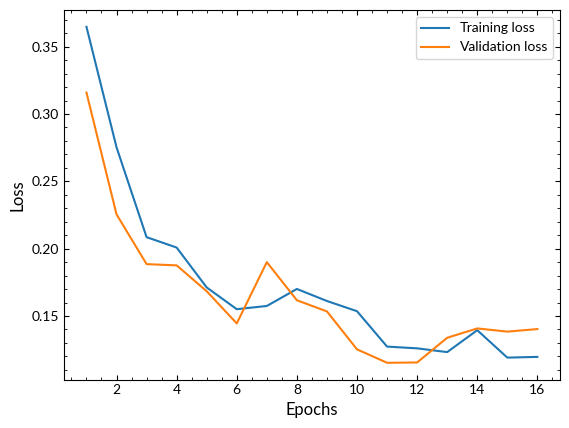

In [22]:
hypertuner.plot_losses()

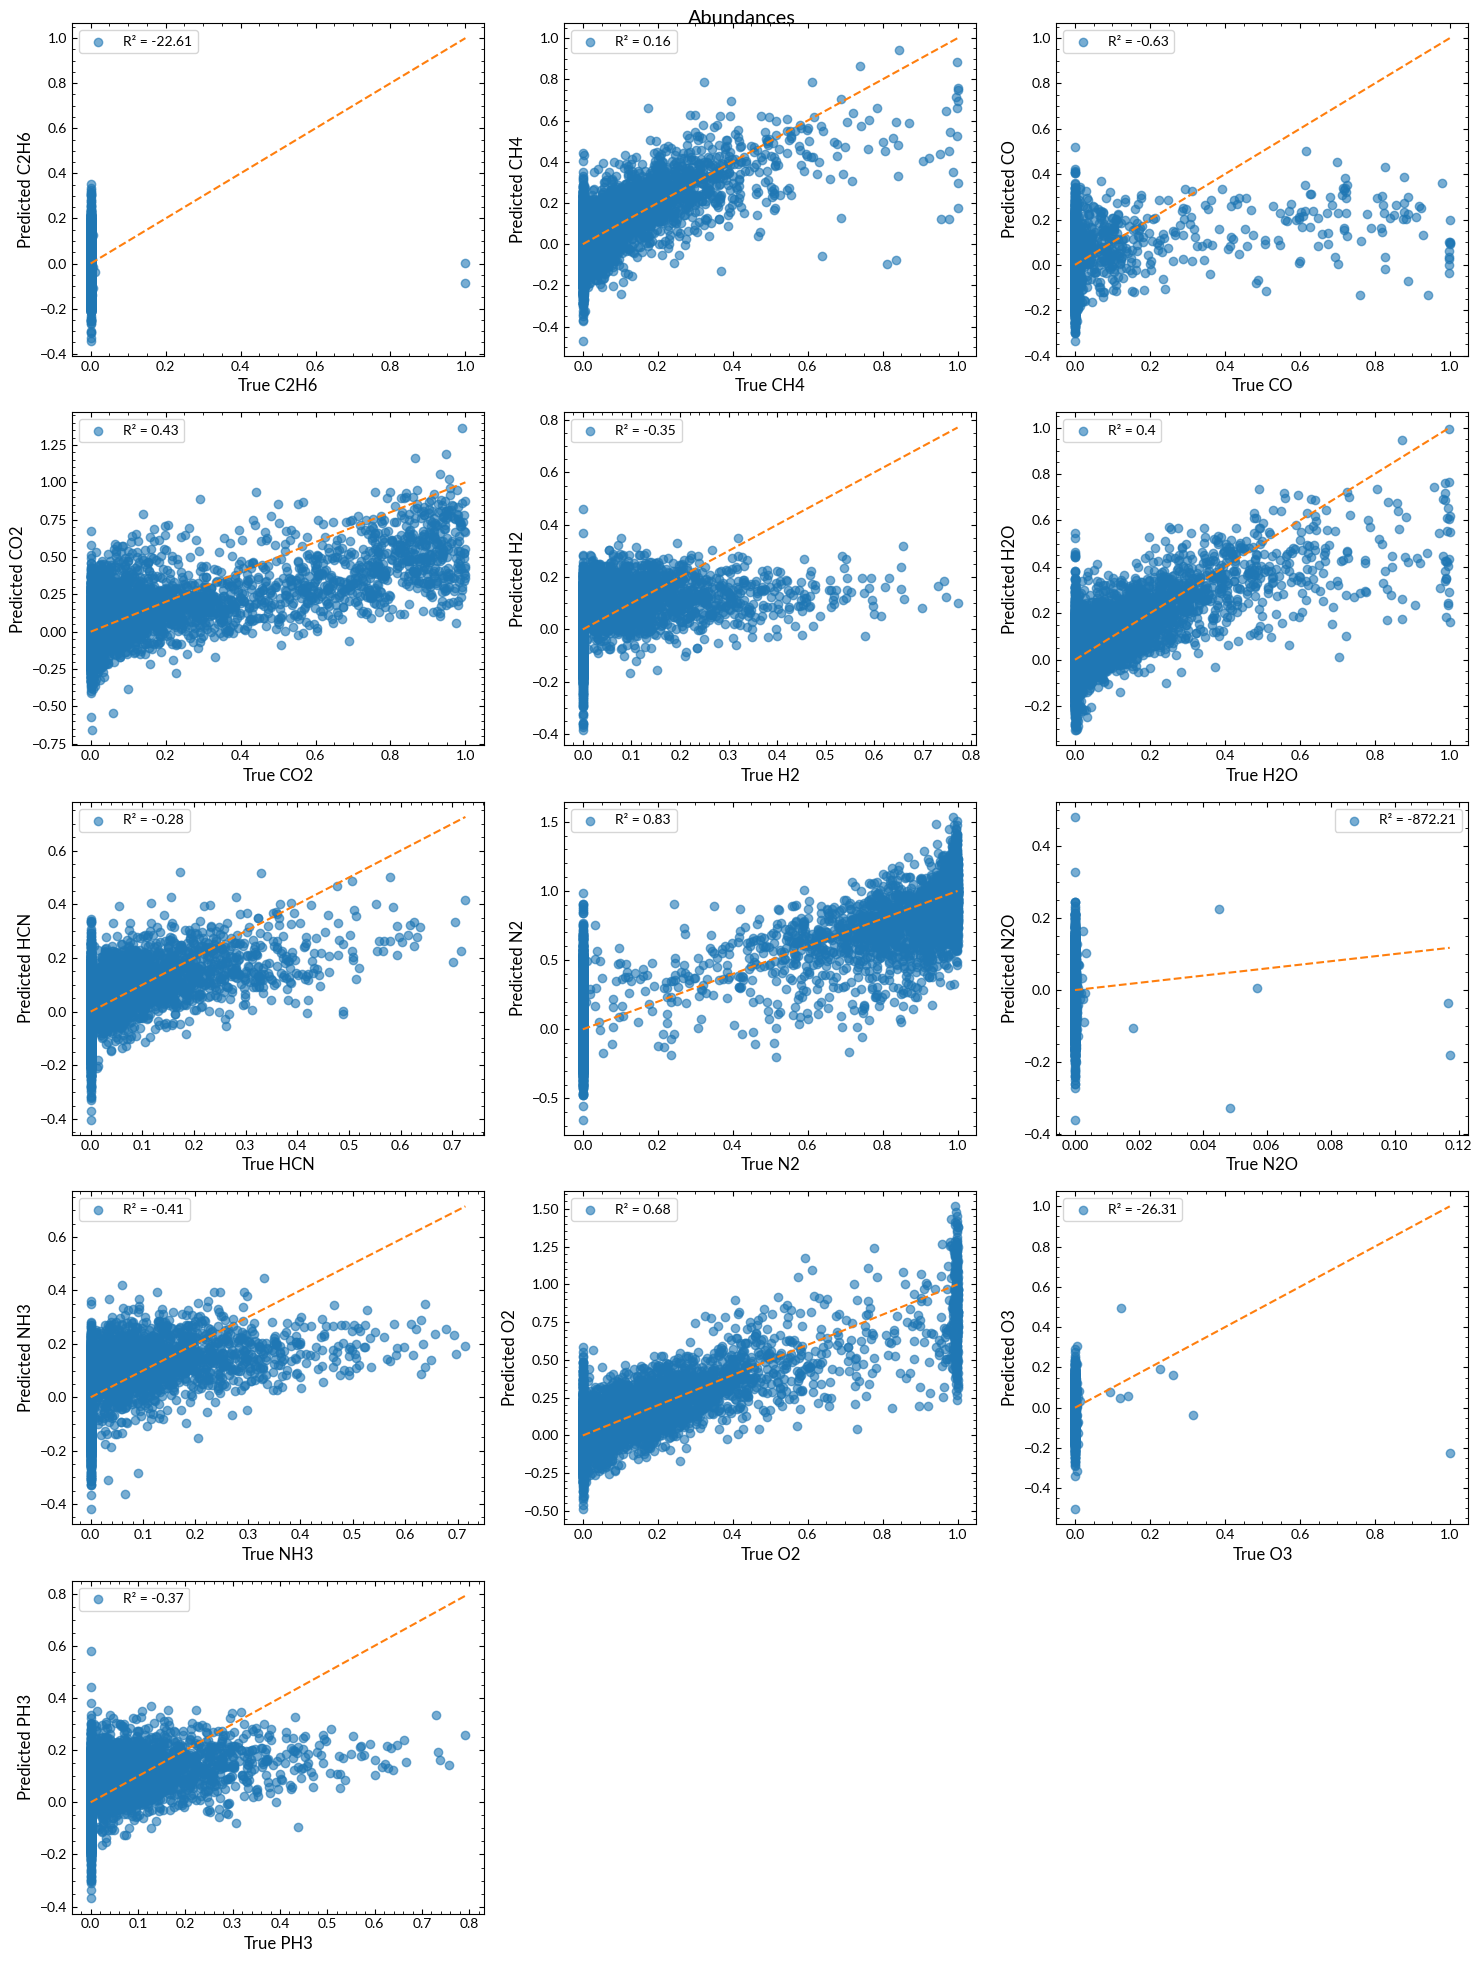

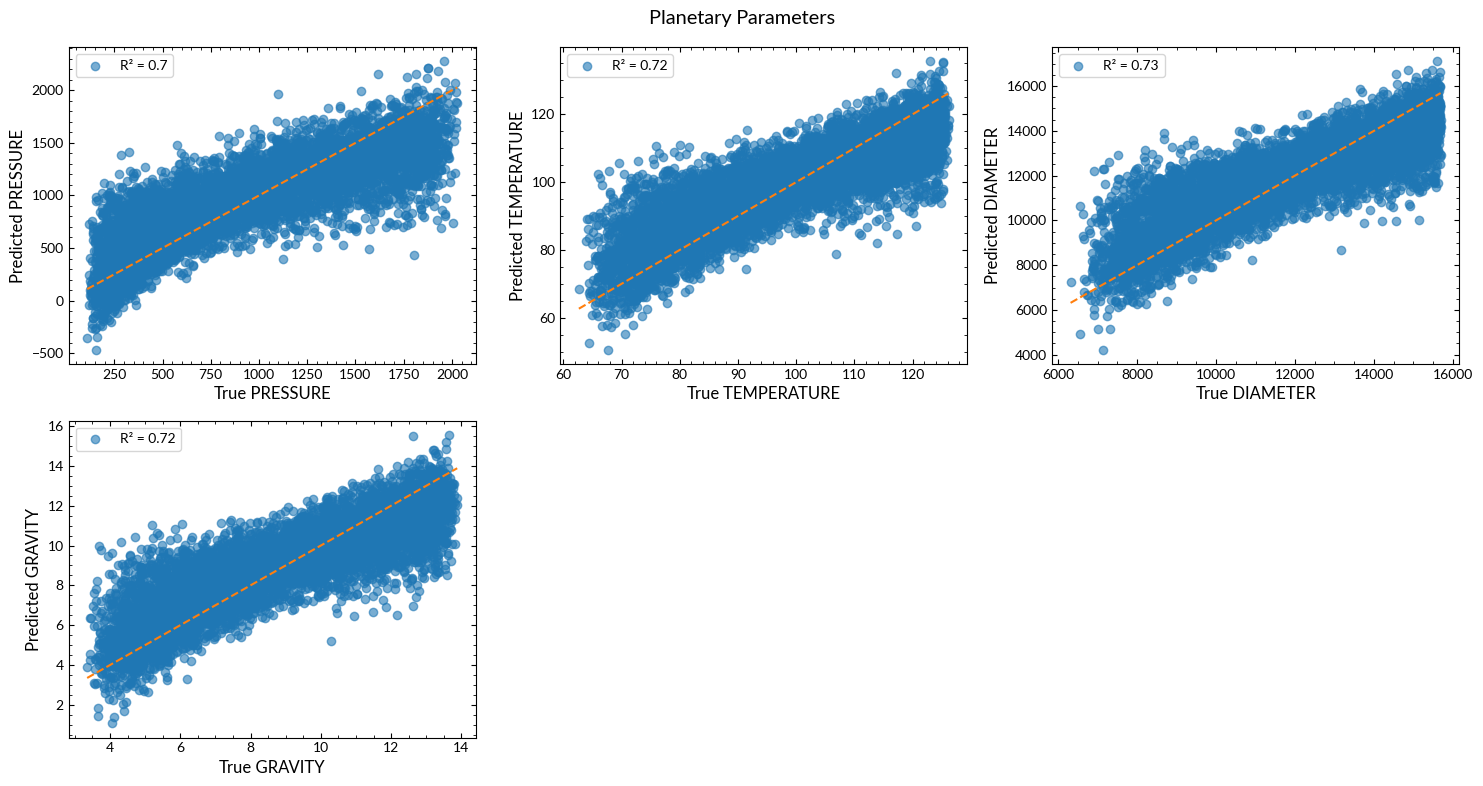

In [23]:
result = hypertuner.evaluate(test_dataset, abundance_features, planetary_features, y_scalers_abundance, y_scalers_planetary)

In [24]:
result["Abundances"]

,R² scores,MAE scores,RMSE scores
C2H6,-22.61,0.06,0.08
CH4,0.16,0.07,0.10
CO,-0.63,0.08,0.11
CO2,0.43,0.12,0.17
H2,-0.35,0.07,0.09
H2O,0.40,0.07,0.10
HCN,-0.28,0.07,0.09
N2,0.83,0.14,0.19
N2O,-872.21,0.05,0.06
NH3,-0.41,0.07,0.10


In [25]:
result["Planetary Parameters"]

,R² scores,MAE scores,RMSE scores
PRESSURE,0.70,209.059998,274.579987
TEMPERATURE,0.72,6.480000,8.520000
DIAMETER,0.73,924.250000,1218.170044
GRAVITY,0.72,1.080000,1.410000


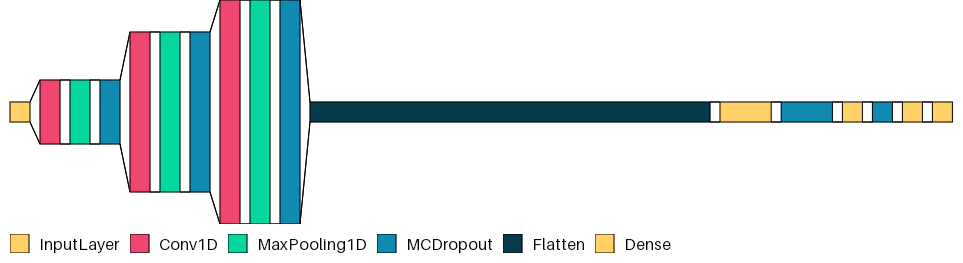

In [26]:
font = ImageFont.load_default(size = 16)

visualkeras.layered_view(hypertuner.best_model, to_file='../images/model_architecture.png', legend=True,
                        draw_funnel=True, draw_volume=False,
                        one_dim_orientation="z", scale_xy=1, font=font)

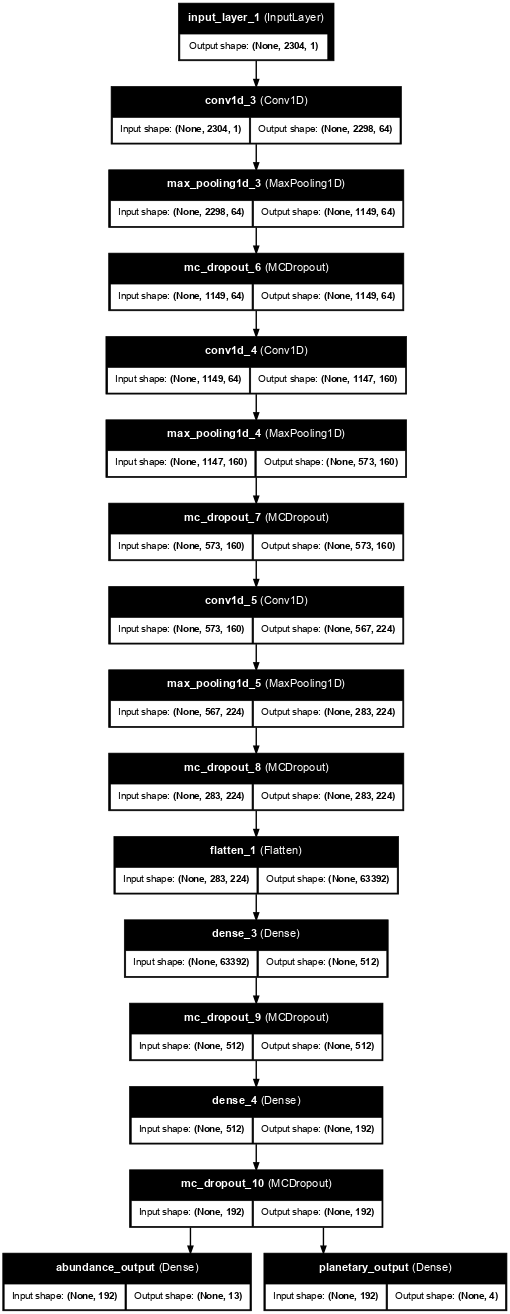

In [27]:
plot_model(hypertuner.best_model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,  rankdir='TB', expand_nested=False, dpi=50)

In [28]:
# Select multiple samples
sample_indices = np.random.choice(len(X_test_scaled), size=100, replace=False)
X_samples = X_test_scaled[sample_indices]

# Generate predictions with uncertainty
n_iter = 100  # Number of Monte Carlo iterations
predictions = hypertuner.predict_with_uncertainty(X_samples, n_iter=n_iter)

predictions_inv = hypertuner.inverse_transform_predictions(
    predictions, y_scalers_abundance, y_scalers_planetary
)

In [29]:
samples_list = []
n_iter, n_samples, n_features = predictions_inv['abundance'].shape
samples = predictions_inv['abundance'].reshape(-1, n_features)
samples_list.append(samples)

# Labels for the samples
sample_labels = ['Model Predictions']

# True values for the selected samples (mean or specific sample)
y_true_abundance = np.mean(y_abundance_test[sample_indices], axis=0)

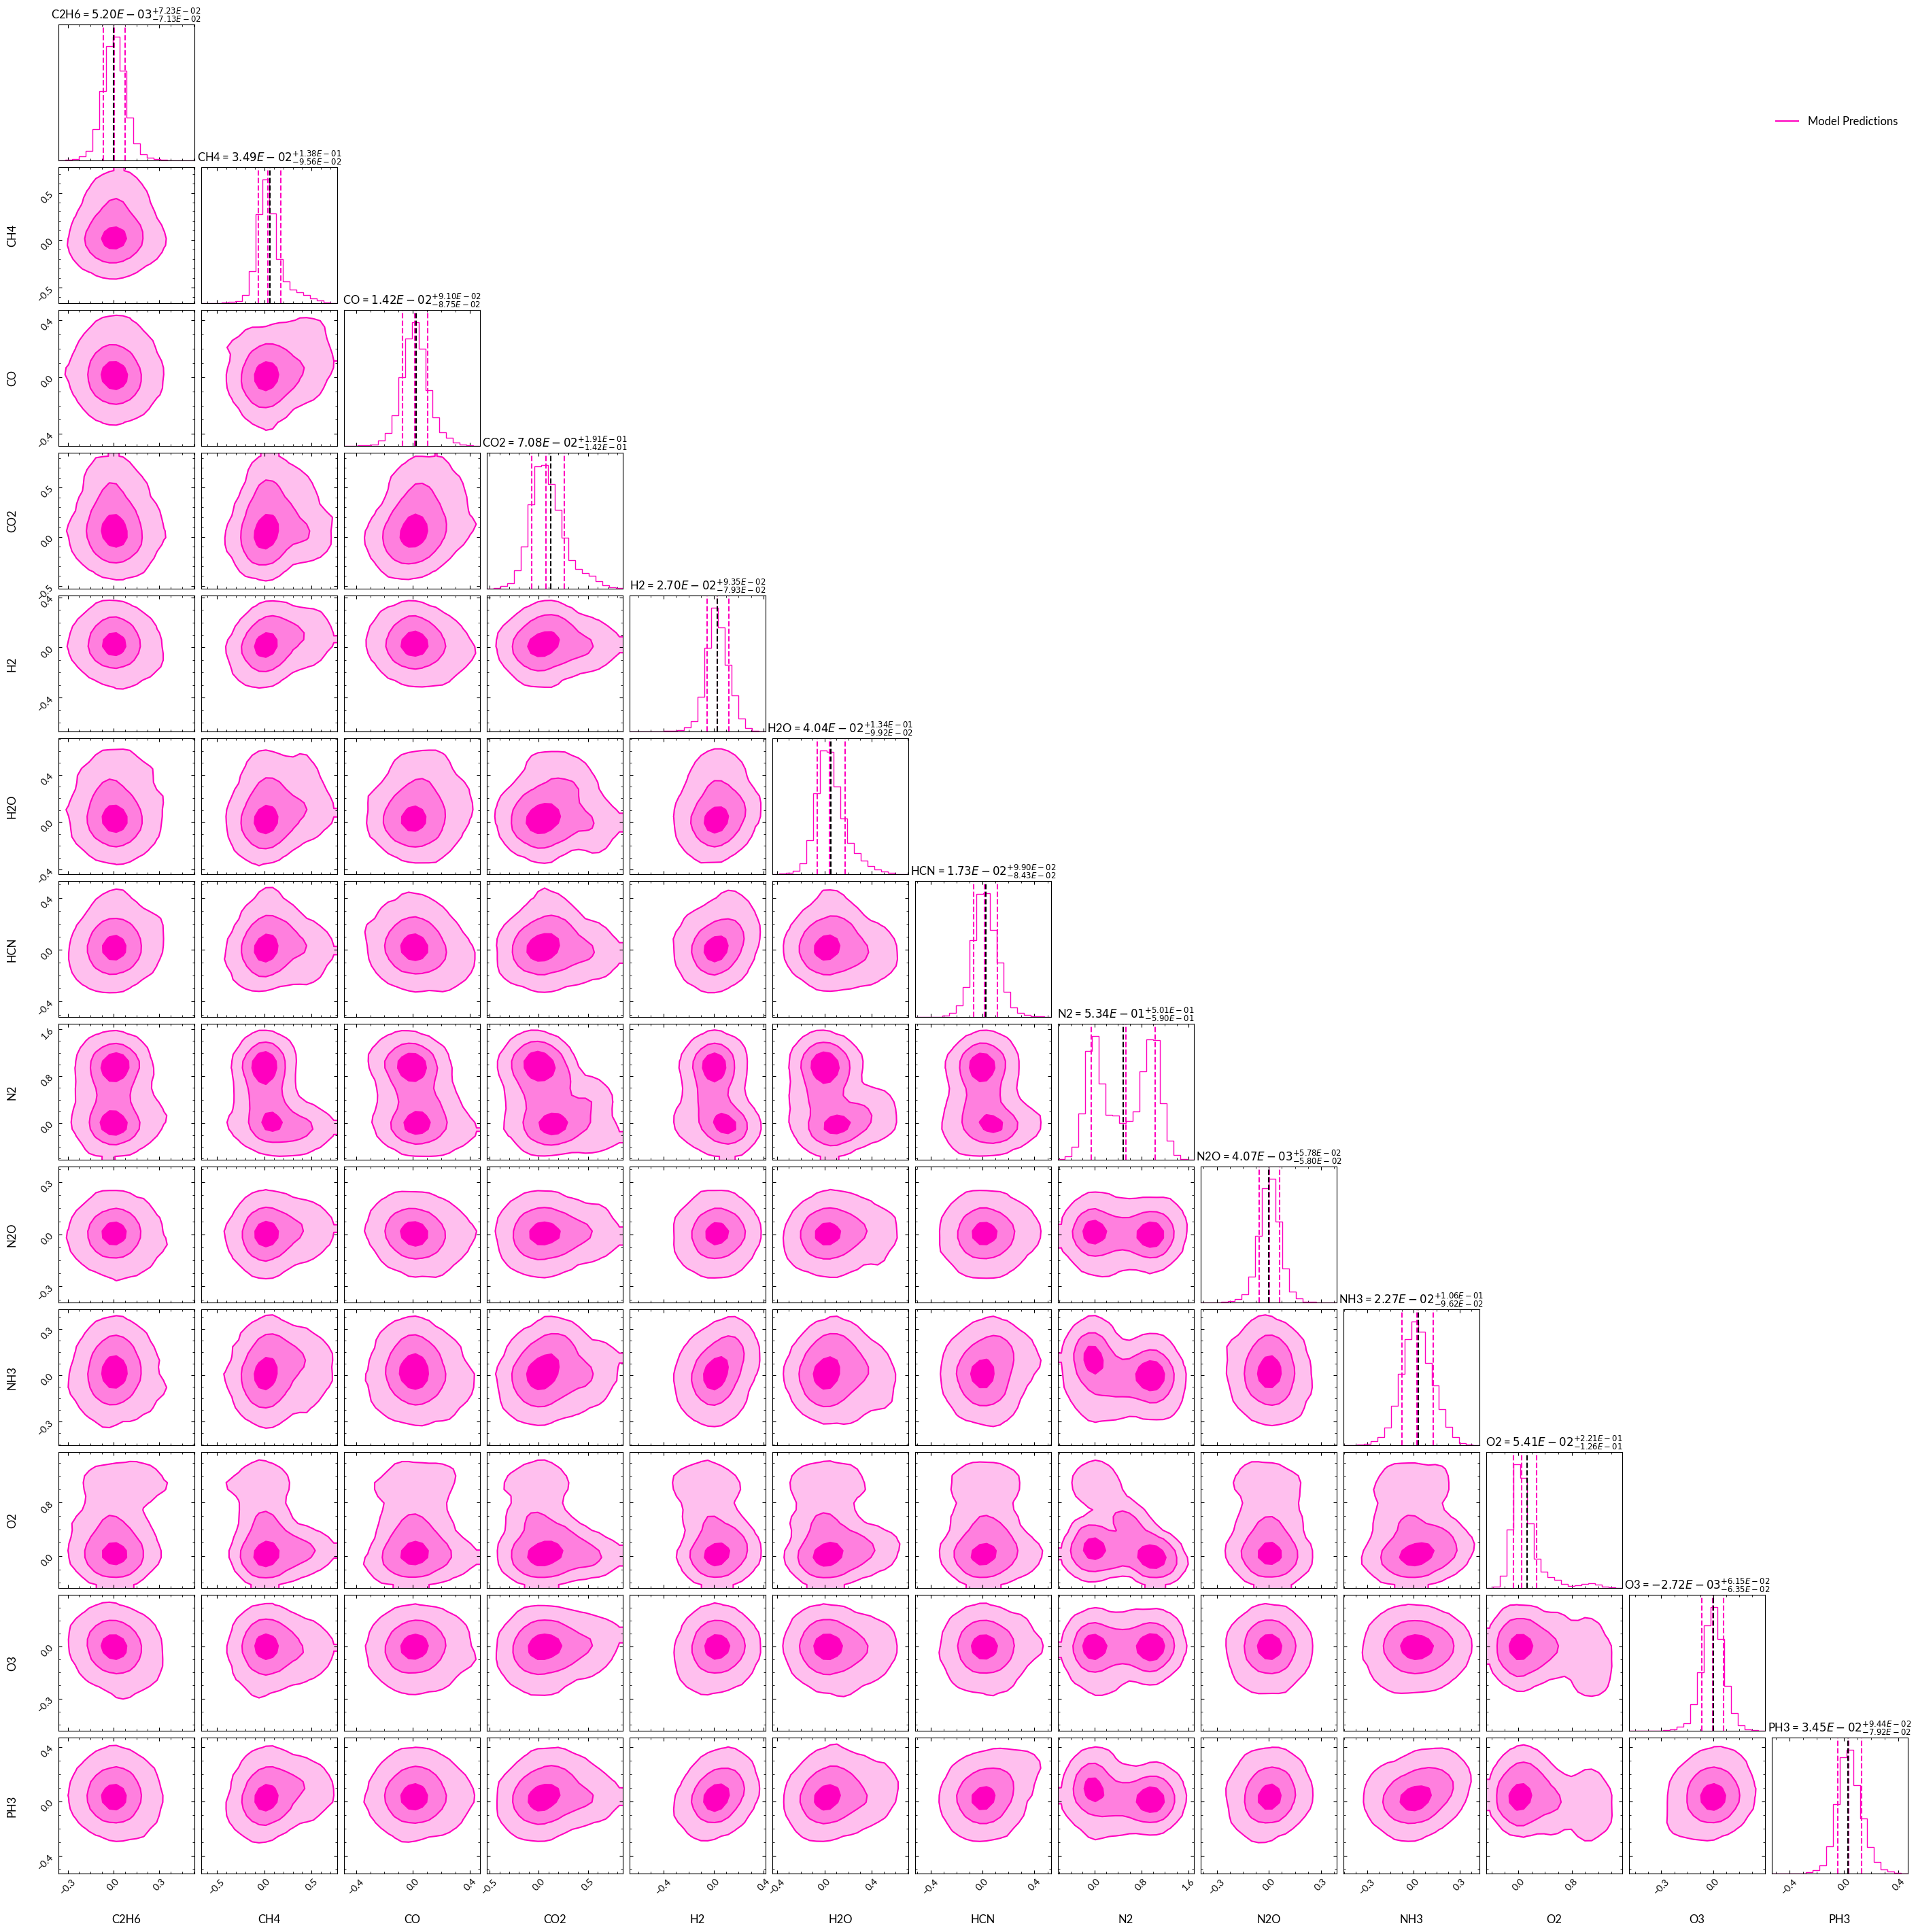

In [30]:
datavis.overlaid_corner(
    samples_list=samples_list,
    sample_labels=sample_labels,
    feature_names=abundance_features,
    true_values=y_true_abundance,
    filename='../images/corner_plot.png'
)